In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
import matplotlib.pyplot as plt
import librosa
import seaborn as sns

In [83]:
# read data
train_df = pd.read_csv('MELD.Raw/train/train_sent_emo.csv')

In [84]:
# set encoders
emotion_encoder = LabelEncoder()
sentiment_encoder = LabelEncoder()
emotion_encoder.fit(train_df['Emotion'])
sentiment_encoder.fit(train_df['Sentiment'])

LabelEncoder()

In [85]:
emotion_distribution = train_df['Emotion'].value_counts(normalize=True)
emotion_distribution

Emotion
neutral     0.471519
joy         0.174492
surprise    0.120633
anger       0.111022
sadness     0.068375
disgust     0.027130
fear        0.026830
Name: proportion, dtype: float64

In [86]:
sentiment_distribution = train_df['Sentiment'].value_counts(normalize=True)
sentiment_distribution

Sentiment
neutral     0.471519
negative    0.294824
positive    0.233657
Name: proportion, dtype: float64

In [87]:
train_df['word_count'] = train_df['Utterance'].apply(lambda x: len(x.split()))

In [88]:
train_df.groupby('Emotion')['word_count'].mean()


Emotion
anger       9.149684
disgust     9.948339
fear        9.085821
joy         7.745267
neutral     7.785563
sadness     9.948755
surprise    6.016598
Name: word_count, dtype: float64

In [89]:
top_10_speakers = train_df.groupby('Speaker', as_index=False)['Speaker'].size()
top_10_speakers = top_10_speakers.sort_values(by='size', ascending=False)
top_10_speakers = top_10_speakers['Speaker'].values[0:10]

In [90]:
top_10_speakers

array(['Joey', 'Ross', 'Rachel', 'Phoebe', 'Monica', 'Chandler', 'Janice',
       'Carol', 'Emily', 'Tag'], dtype=object)

In [91]:
train_df_top_10 = train_df[train_df['Speaker'].isin(top_10_speakers)]

In [92]:
train_df_top_10.groupby('Speaker',)['word_count'].mean()

Speaker
Carol        8.673913
Chandler     8.243959
Emily        9.395349
Janice      10.603448
Joey         7.838304
Monica       7.887606
Phoebe       8.043149
Rachel       7.859930
Ross         7.980809
Tag          6.146341
Name: word_count, dtype: float64

In [93]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Function to generate and display word clouds
def generate_word_clouds(df, column):
    # Unique categories
    categories = df[column].unique()
    
    # Figure setup
    plt.figure(figsize=(20, 10))
    
    # Generate a word cloud for each category
    for i, category in enumerate(categories, 1):
        # Aggregate text for the current category
        text = " ".join(df[df[column] == category]['Utterance'].tolist())
        
        # Generate word cloud
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text)
        
        # Plot
        plt.subplot(1, len(categories), i)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{category} {column}')
        plt.axis('off')
    
    plt.show()


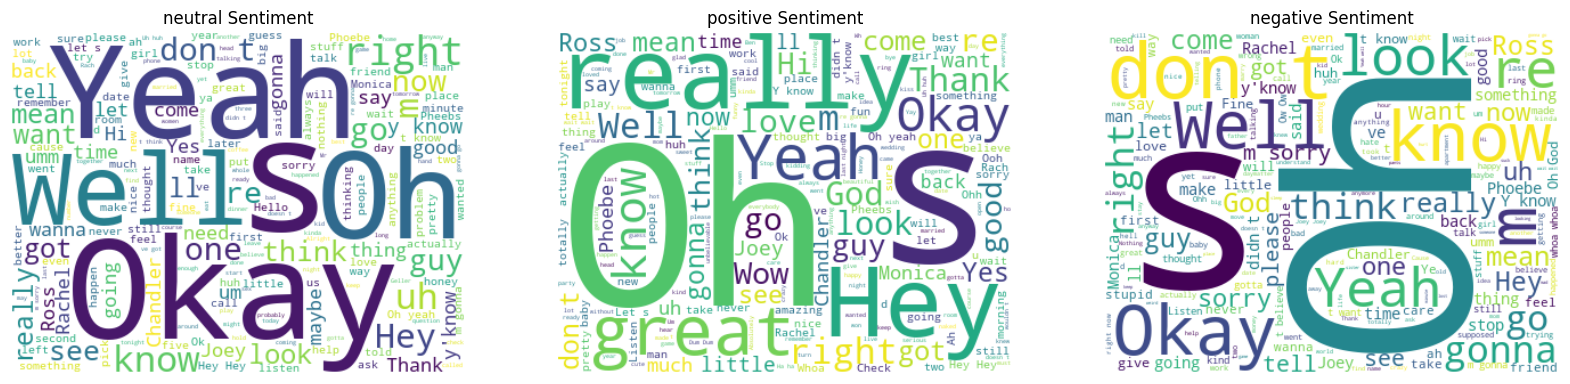

In [94]:
generate_word_clouds(train_df, 'Sentiment')

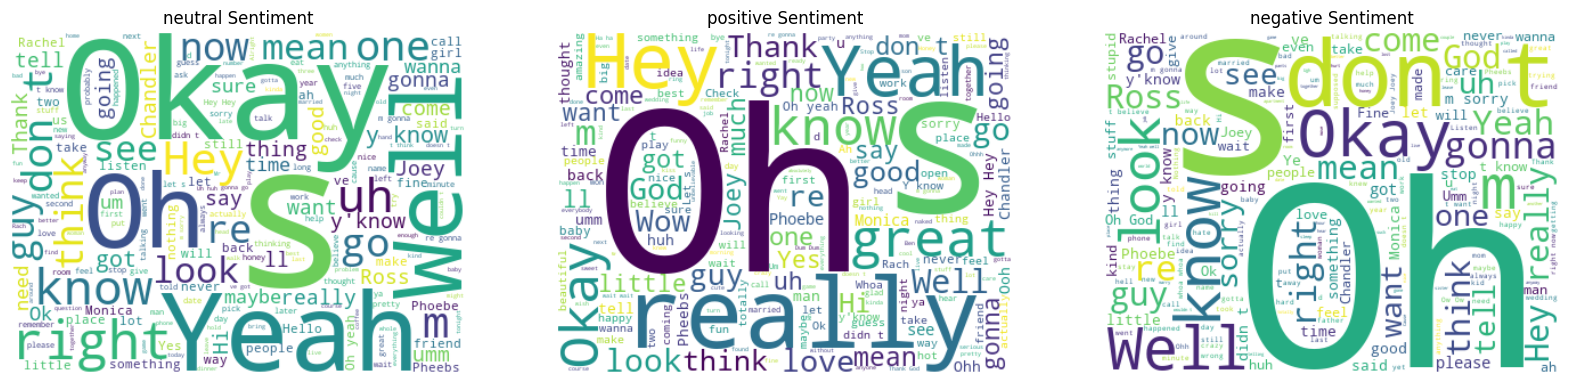

In [95]:
generate_word_clouds(train_df_top_10, 'Sentiment')

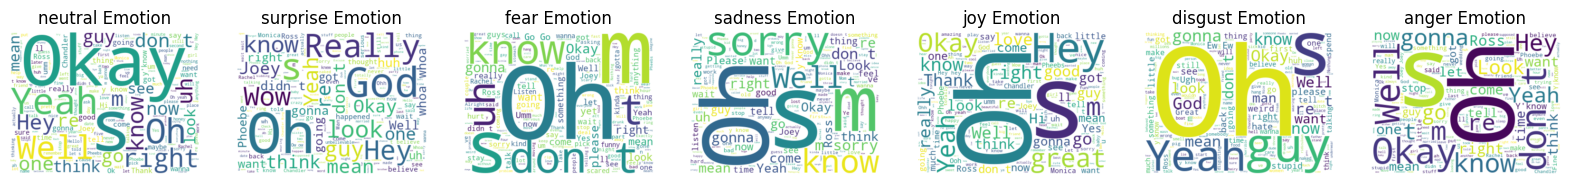

In [96]:
generate_word_clouds(train_df_top_10, 'Emotion')

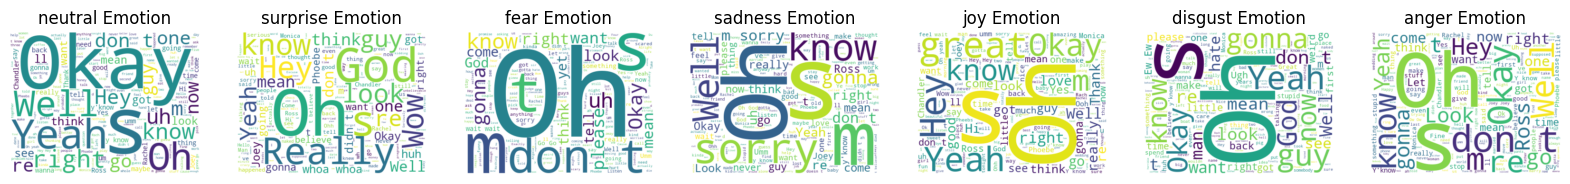

In [97]:
generate_word_clouds(train_df, 'Emotion')


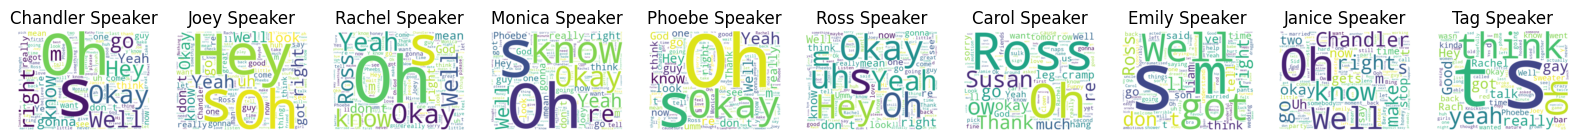

In [98]:
generate_word_clouds(train_df_top_10, 'Speaker')

In [6]:
with open('../AudioFeaturesExtraction/dev_data.pkl','rb') as file:
    dev_audio_dict = pickle.load(file)

In [7]:
def positive_fft(waveform, sr):
    """
    This function computes the FFT of a waveform and returns the positive frequency components and their magnitudes.
    
    Parameters:
    - waveform: The audio waveform array.
    - sr: Sample rate of the audio data.
    
    Returns:
    - pos_frequencies: Positive frequency values.
    - pos_magnitudes: Magnitudes of the FFT at positive frequencies.
    """
    fft_values = np.fft.fft(waveform)
    frequencies = np.fft.fftfreq(len(waveform), 1/sr)
    
    # Filter positive frequencies
    mask = frequencies >= 0
    pos_frequencies = frequencies[mask]
    pos_magnitudes = np.abs(fft_values[mask])
    
    return pos_frequencies, pos_magnitudes

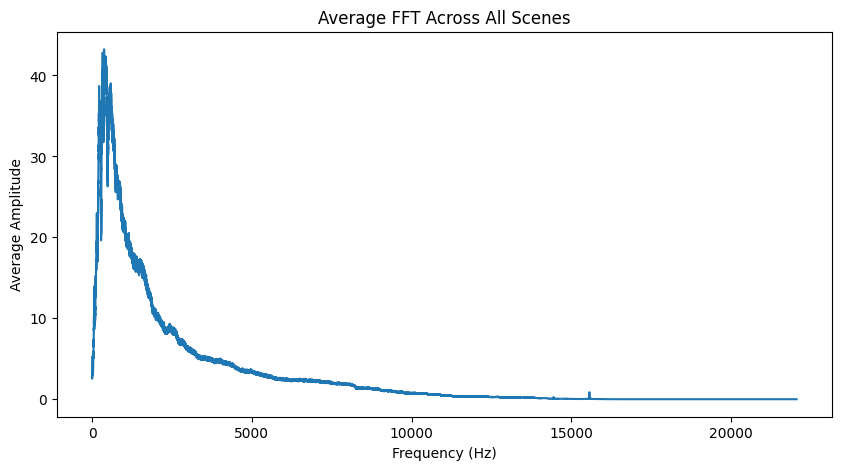

In [13]:
def plot_average_fft(audio_dict, sample_rate):
    sum_fft = None
    count = 0

    for scene_id, data in audio_dict.items():
        waveform = data['waveforms'][0].numpy()
        pos_frequencies, pos_magnitudes = positive_fft(waveform, sample_rate)
        
        # Initialize sum_fft if it's the first scene
        if sum_fft is None:
            sum_fft = np.zeros_like(pos_magnitudes)
        
        # Sum the FFT magnitudes
        sum_fft += pos_magnitudes
        count += 1

    # Calculate average FFT
    avg_fft = sum_fft / count

    # Plot the average FFT
    plt.figure(figsize=(10, 5))
    plt.plot(pos_frequencies, avg_fft)
    plt.title('Average FFT Across All Scenes')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Average Amplitude')
    plt.show()

plot_average_fft(dev_audio_dict, 44100)


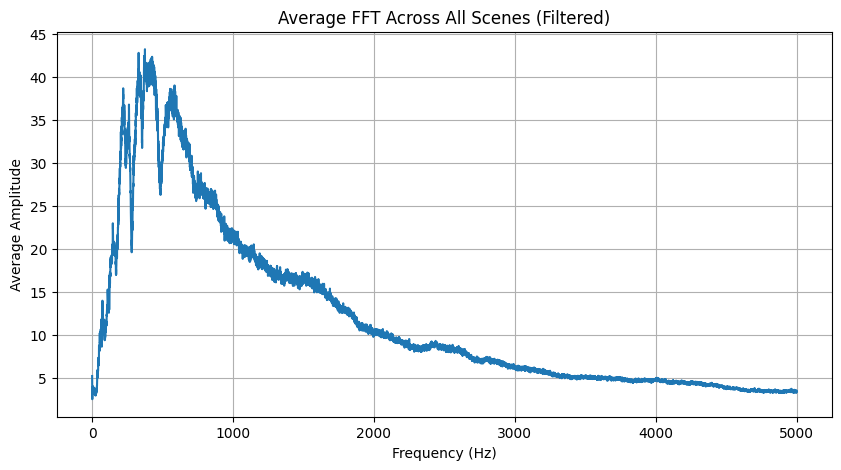

In [15]:
def plot_average_filtered_fft(audio_dict, sr, max_freq=5000):
    """
    Computes the average FFT of multiple waveforms stored in a dictionary, and plots the magnitudes up to a specified maximum frequency.
    
    Parameters:
    - audio_dict: Dictionary containing multiple audio data entries. Each entry is expected to have a 'waveforms' key with an audio waveform array.
    - sr: Sample rate of the audio data.
    - max_freq: The maximum frequency to display in the plot.
    """
    sum_fft = None
    count = 0

    for scene_id, data in audio_dict.items():
        waveform = data['waveforms'][0].numpy()  # Extract waveform and convert to numpy array if necessary
        fft_values = np.fft.fft(waveform)
        frequencies = np.fft.fftfreq(len(waveform), 1 / sr)
        magnitudes = np.abs(fft_values)
        
        # Filter to only show up to max_freq
        mask = (frequencies >= 0) & (frequencies <= max_freq)
        filtered_frequencies = frequencies[mask]
        filtered_magnitudes = magnitudes[mask]
        
        # Initialize sum_fft if it's the first scene
        if sum_fft is None:
            sum_fft = np.zeros_like(filtered_magnitudes)
        
        # Sum the FFT magnitudes
        sum_fft += filtered_magnitudes
        count += 1

    # Calculate average FFT
    avg_fft = sum_fft / count

    # Plot the average FFT
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_frequencies, avg_fft)
    plt.title('Average FFT Across All Scenes (Filtered)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Average Amplitude')
    plt.grid(True)
    plt.show()

plot_average_filtered_fft(dev_audio_dict, 44100, 5000)

In [29]:
def extract_features(waveform, sr):
    """
    Calculate various spectral features and return them in a dictionary.
    """
    # Basic spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform, sr=sr)[0]
    spectral_flatness = librosa.feature.spectral_flatness(y=waveform)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr)[0]
    rms_energy = librosa.feature.rms(y=waveform)[0]
    zcr = librosa.feature.zero_crossing_rate(waveform)[0]
    mfccs = librosa.feature.mfcc(y=waveform, sr=sr)
    chroma = librosa.feature.chroma_stft(y=waveform, sr=sr)

    # Initialize the feature dictionary
    features = {
        'centroid_mean': np.mean(spectral_centroid),
        'bandwidth_mean': np.mean(spectral_bandwidth),
        'flatness_mean': np.mean(spectral_flatness),
        'rolloff_mean': np.mean(spectral_rolloff),
        'rms_energy_mean': np.mean(rms_energy),
        'zcr_mean': np.mean(zcr)
    }

    # Adding MFCCs and Chroma features
    for i in range(mfccs.shape[0]):  # Assuming MFCCs are returned with shape (n_mfcc, t)
        features[f'mfccs_mean_{i}'] = np.mean(mfccs[i, :])

    for i in range(chroma.shape[0]):  # Assuming Chroma features are returned with shape (n_chroma, t)
        features[f'chroma_mean_{i}'] = np.mean(chroma[i, :])

    return features

def process_audio_data(audio_dict, sample_rate):
    """
    Process each audio scene, extract features, and compile them into a single DataFrame.
    """
    feature_list = []

    for scene_id, data in audio_dict.items():
        waveform = data['waveforms'][0].numpy()  # Ensure waveform is a NumPy array
        features = extract_features(waveform, sample_rate)
        features['scene_id'] = scene_id  # Add scene_id to the features dictionary
        feature_list.append(features)
    
    # Create a DataFrame from the list of feature dictionaries
    combined_features_df = pd.DataFrame(feature_list)
    return combined_features_df

sample_rate = 44100  # Common sample rate for high-quality audio
feature_data = process_audio_data(dev_audio_dict, sample_rate)
print(feature_data.head())

   centroid_mean  bandwidth_mean  flatness_mean  rolloff_mean  \
0    2727.880141     2988.399904       0.000104   5535.606405   
1    1221.147500     1498.615474       0.452543   2580.542996   
2    1696.000773     1347.903054       0.000056   2419.388110   
3    1812.193405     1647.474139       0.000034   3105.599181   
4    1372.067098     1385.305496       0.315496   2455.473432   

   rms_energy_mean  zcr_mean  mfccs_mean_0  mfccs_mean_1  mfccs_mean_2  \
0         0.034789  0.068640   -317.934723    149.615005    -26.254499   
1         0.012444  0.026744   -517.735474     91.882820    -20.204626   
2         0.012437  0.065769   -464.894470    196.504074    -54.127068   
3         0.106447  0.060672   -182.120071    210.736267    -99.080322   
4         0.007548  0.039546   -563.605103    119.953865    -34.296616   

   mfccs_mean_3  ...  chroma_mean_3  chroma_mean_4  chroma_mean_5  \
0     49.872192  ...       0.419102       0.372151       0.379163   
1     18.317453  ...      

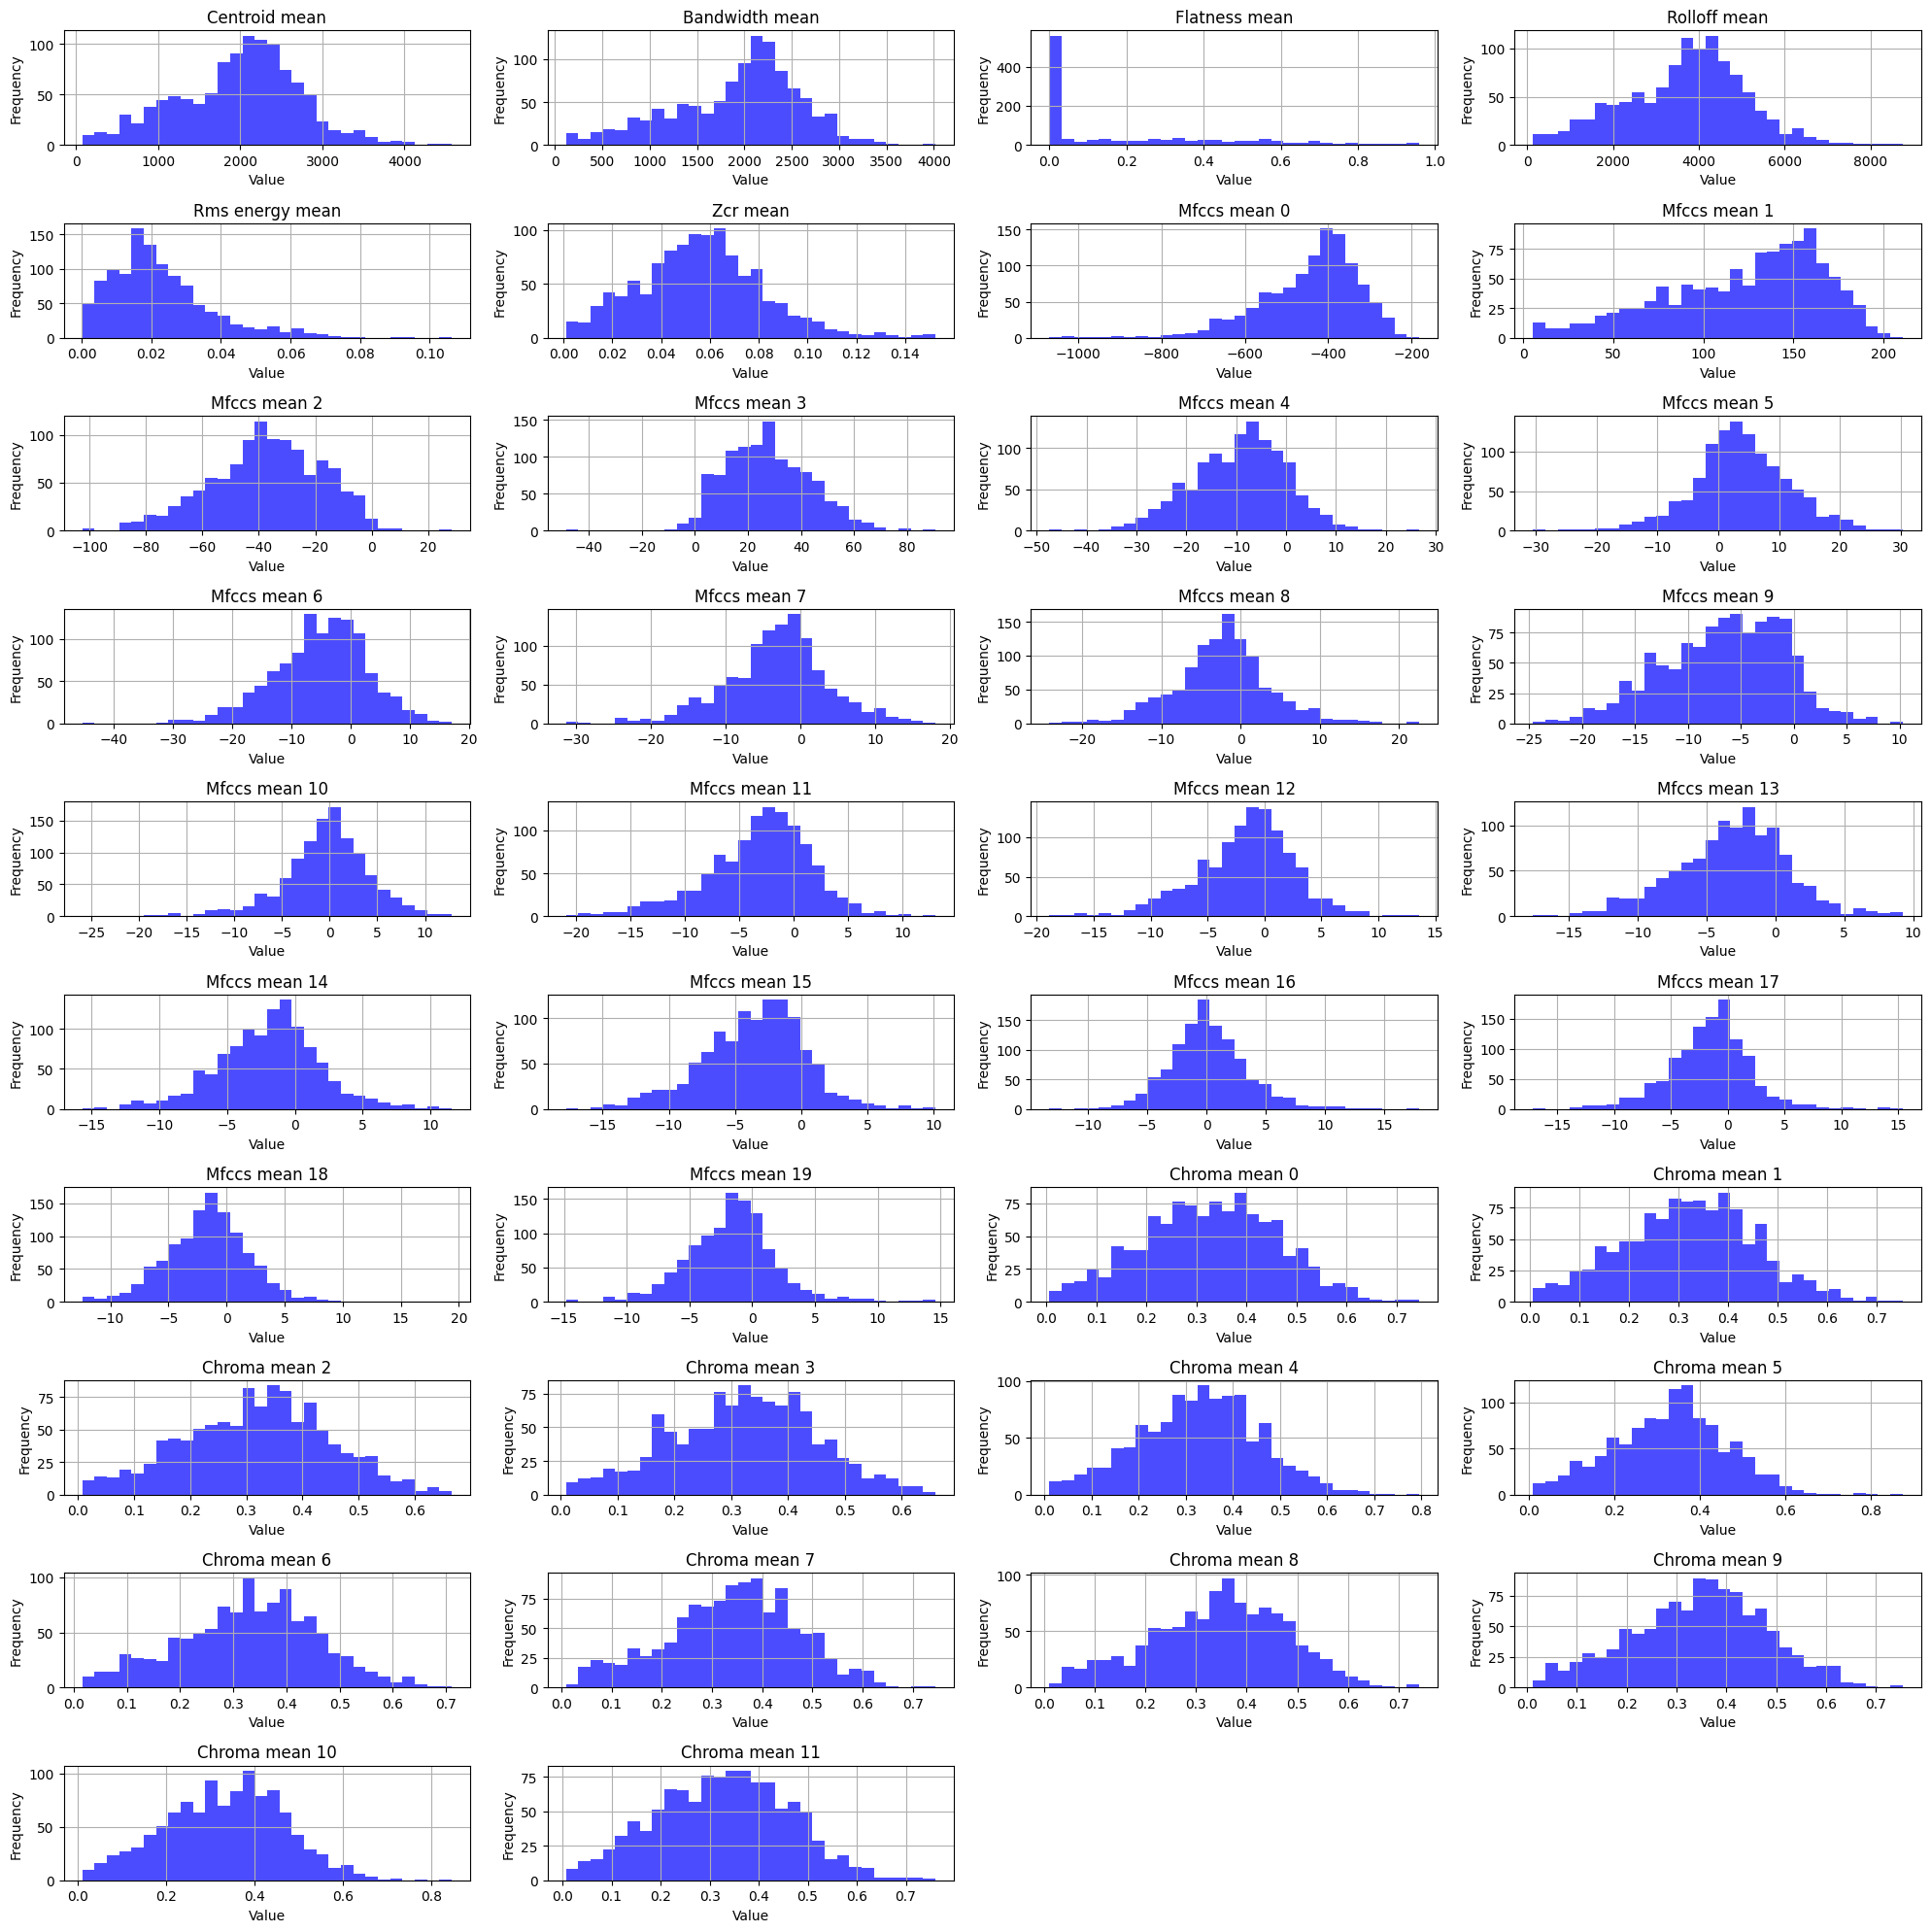

In [31]:
def plot_feature_distributions(feature_data):
    """
    Plots histograms for each spectral feature in the feature DataFrame.
    
    Parameters:
    - feature_data: DataFrame containing the extracted audio features.
    """
    # Prepare the figure layout
    plt.figure(figsize=(20, 20))  # Adjust size as needed for clarity

    # Automatically fetch all feature names except 'scene_id' if it's part of the DataFrame
    features = [col for col in feature_data.columns if col not in ['scene_id']]

    # Determine the number of rows and columns for the subplot grid
    total_features = len(features)
    columns = 4  # Number of columns in the plot grid
    rows = (total_features + columns - 1) // columns  # Calculate required number of rows

    # Create subplots for each feature
    for i, feature in enumerate(features):
        ax = plt.subplot(rows, columns, i + 1)
        # Use a consistent number of bins and alpha transparency for clarity
        plt.hist(feature_data[feature], bins=30, alpha=0.7, color='blue')
        plt.title(feature.replace('_', ' ').capitalize())
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

plot_feature_distributions(feature_data)

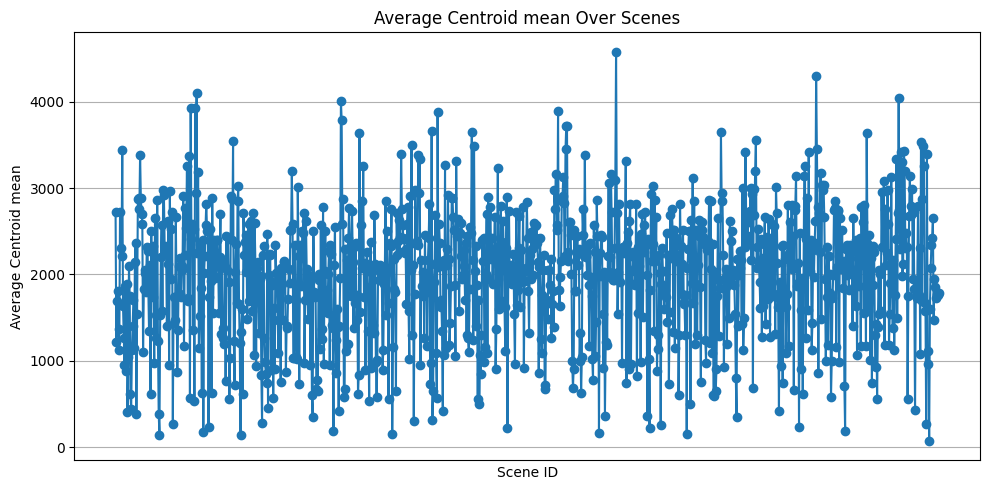

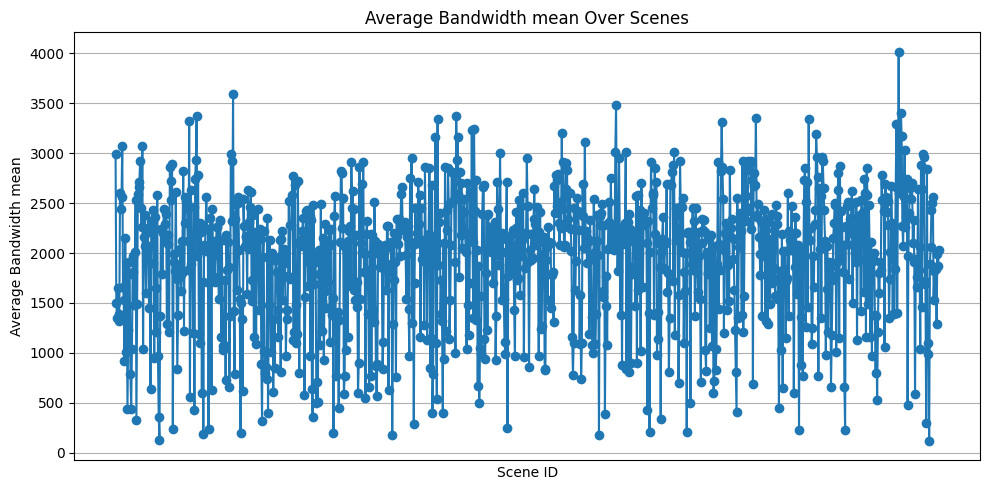

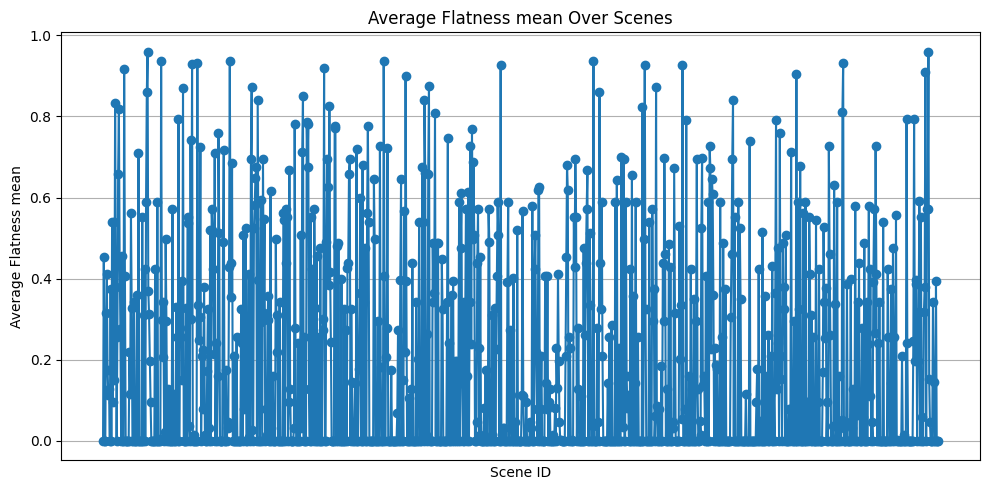

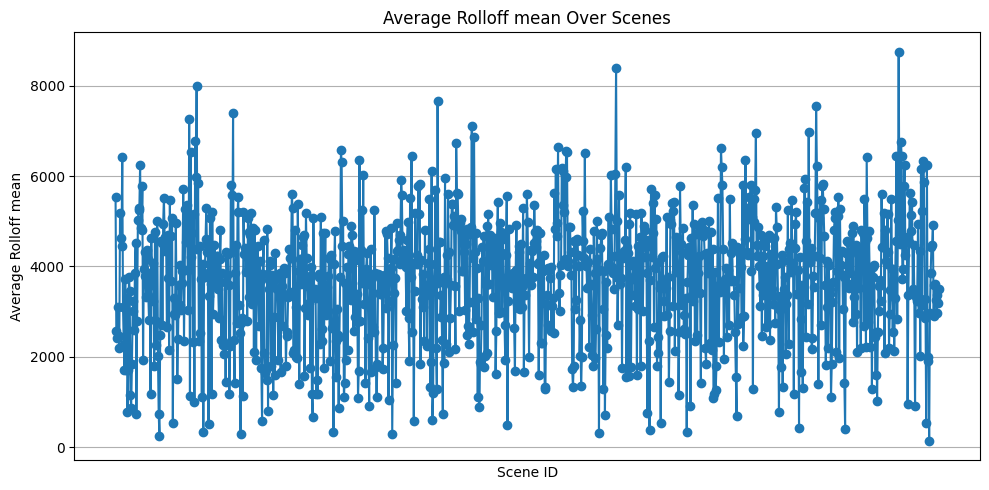

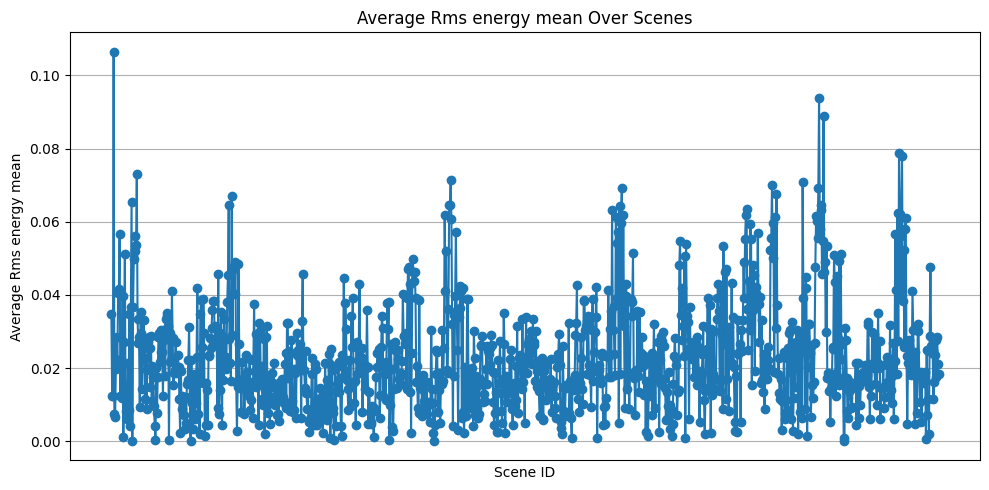

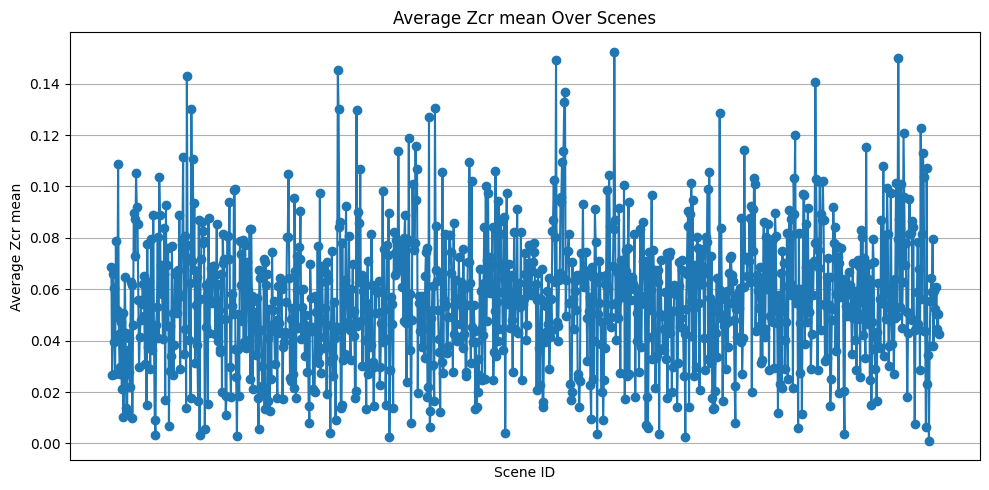

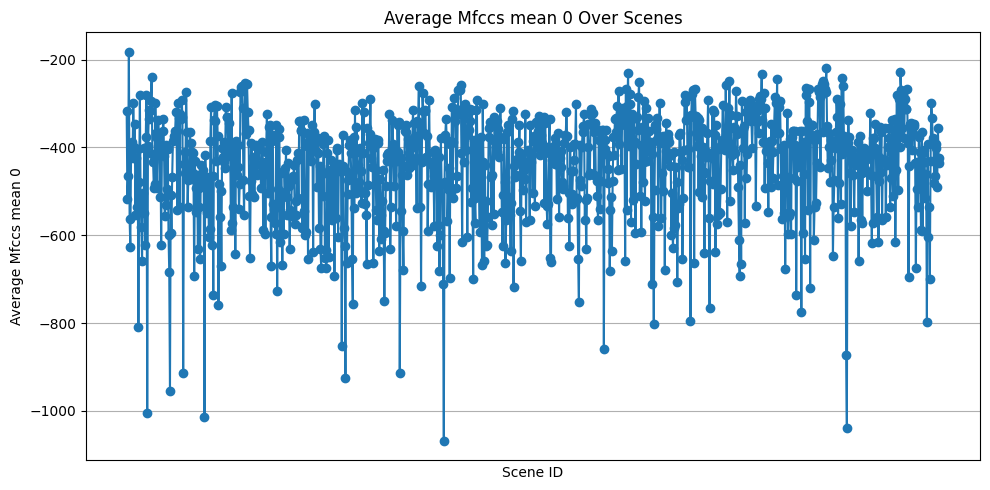

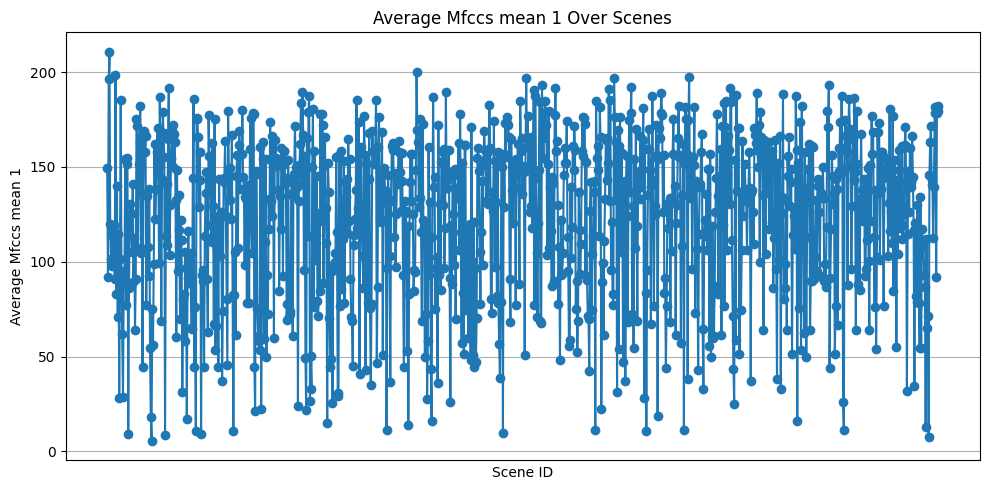

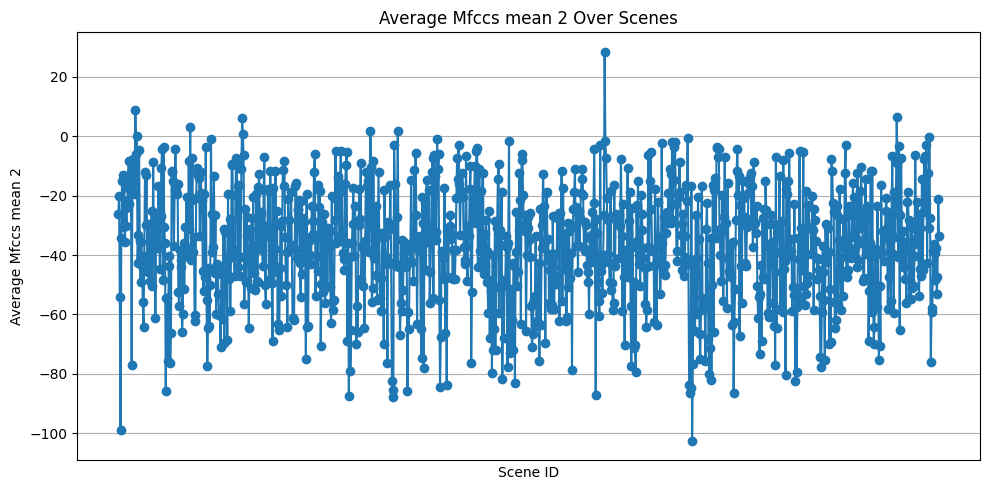

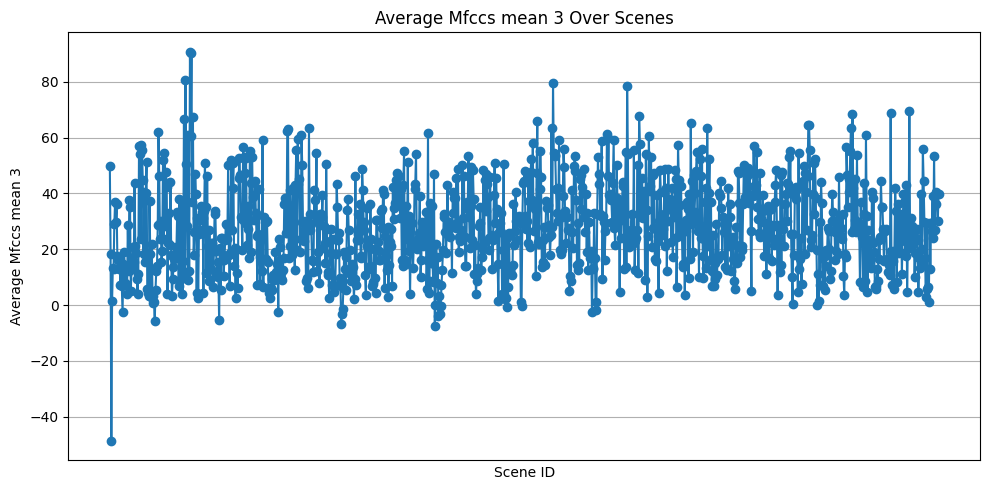

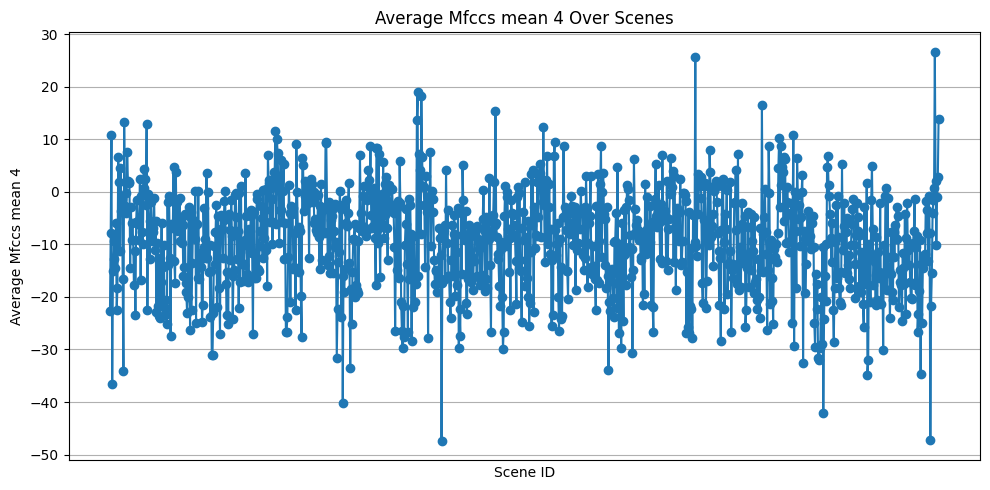

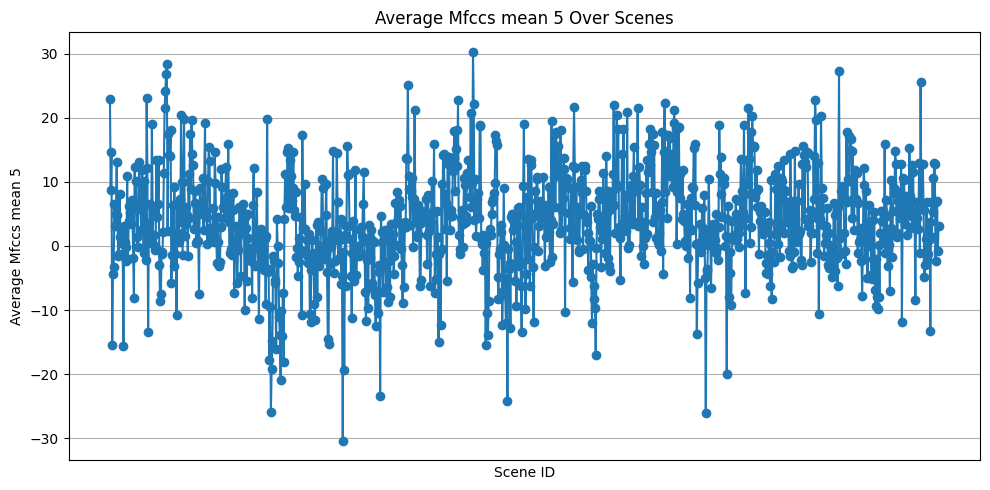

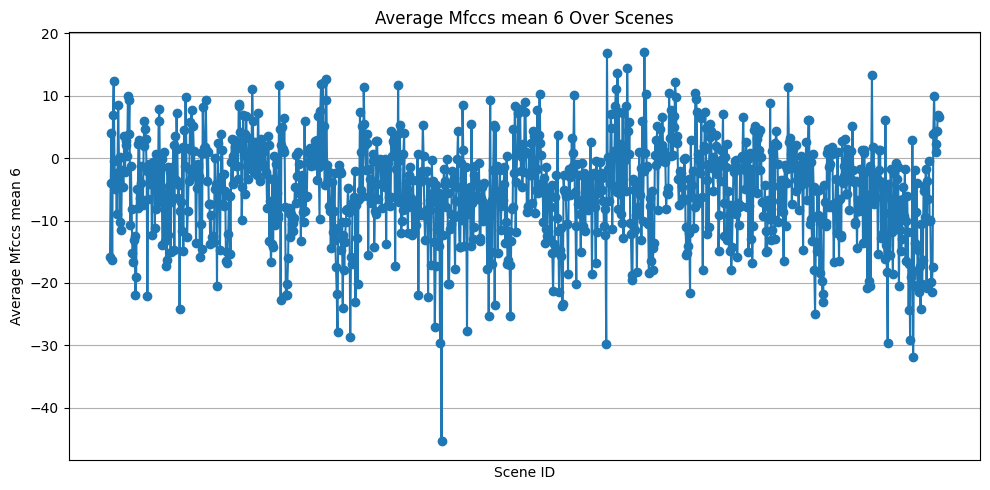

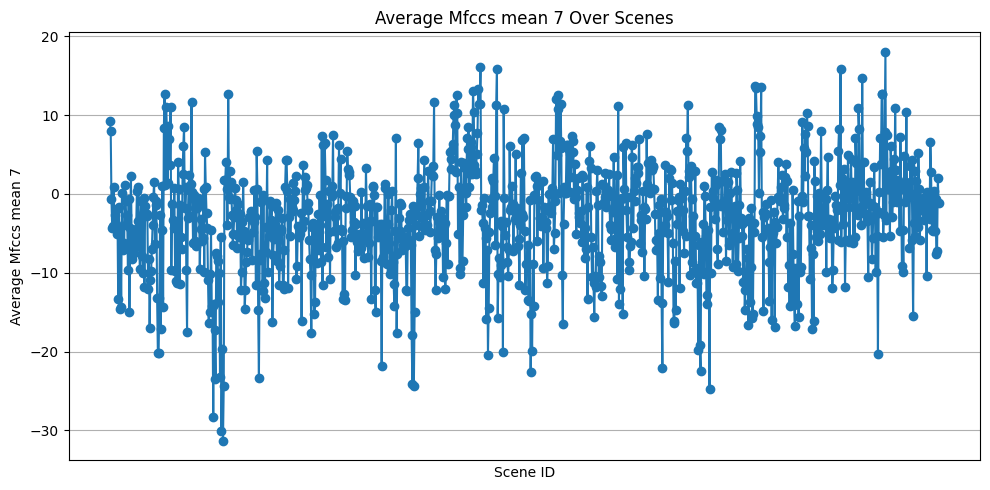

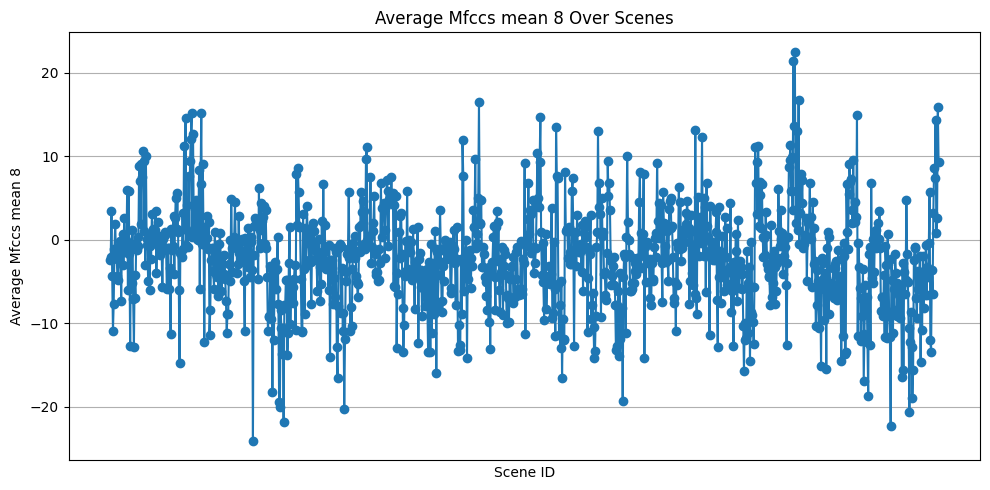

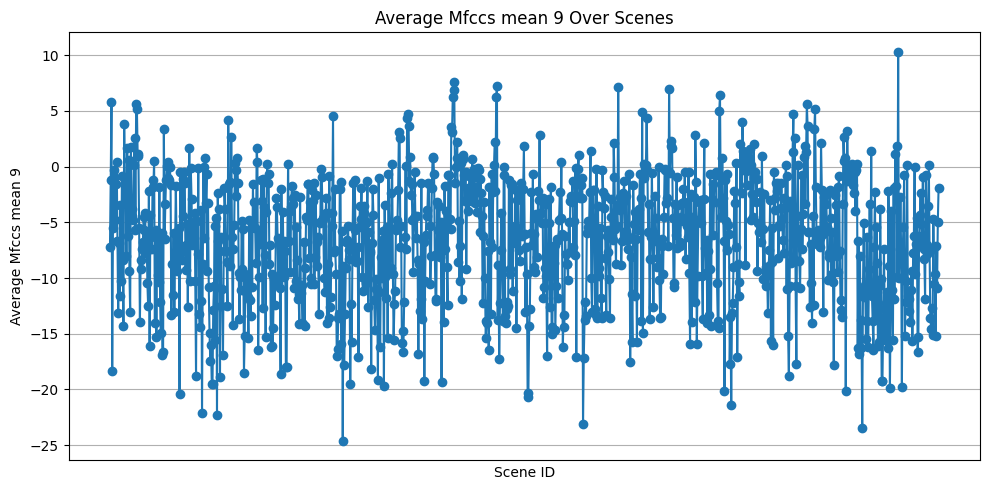

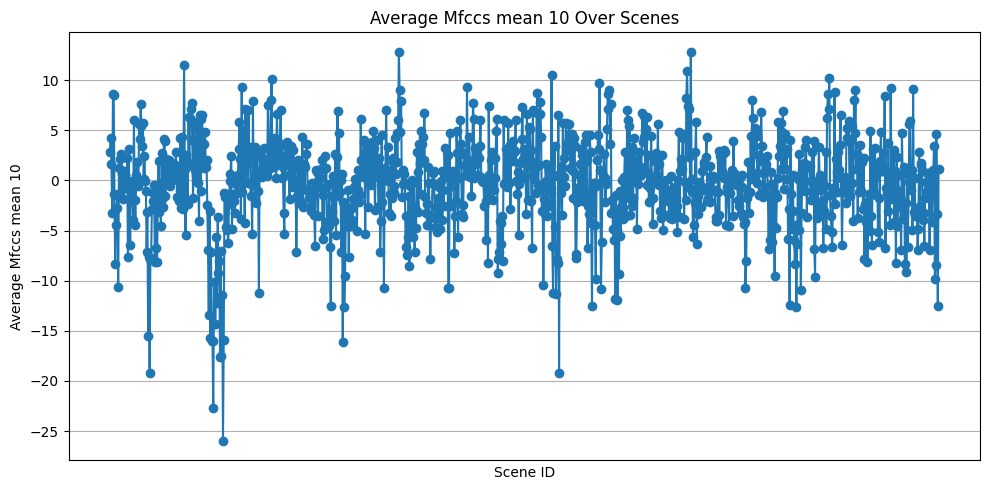

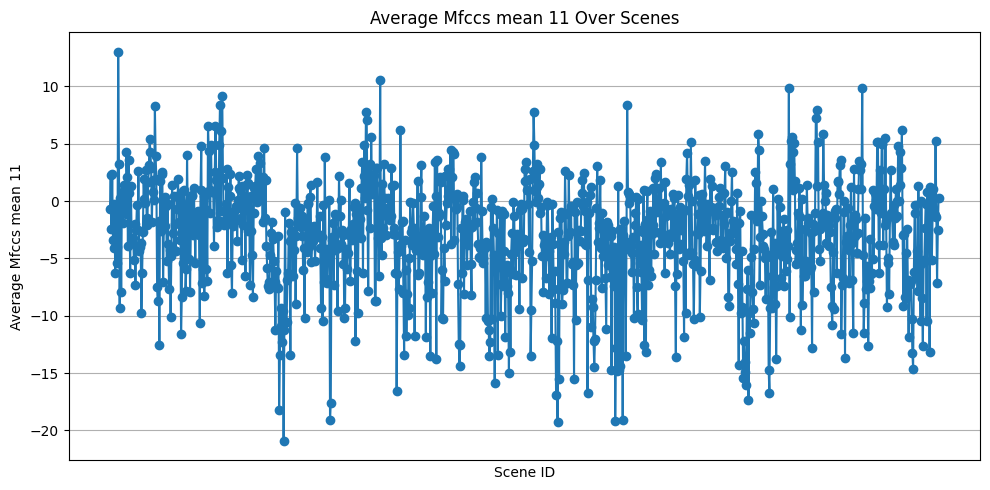

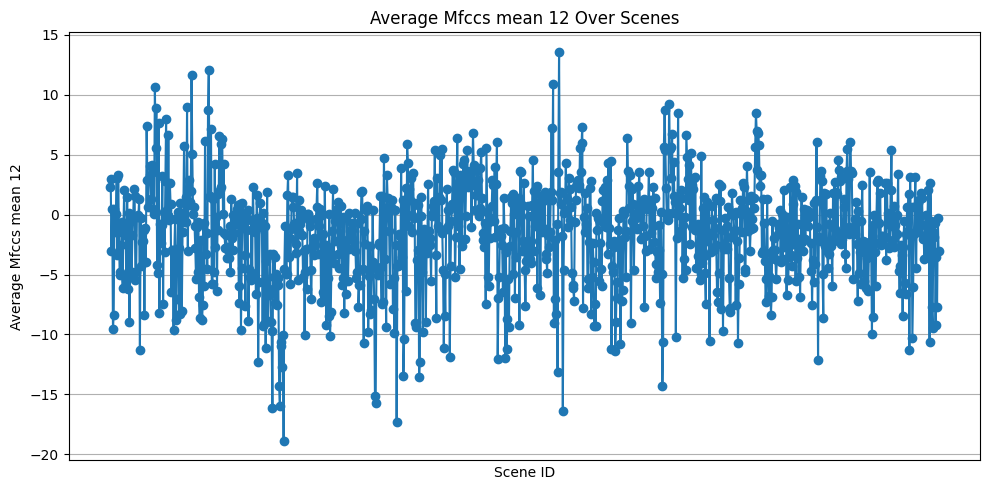

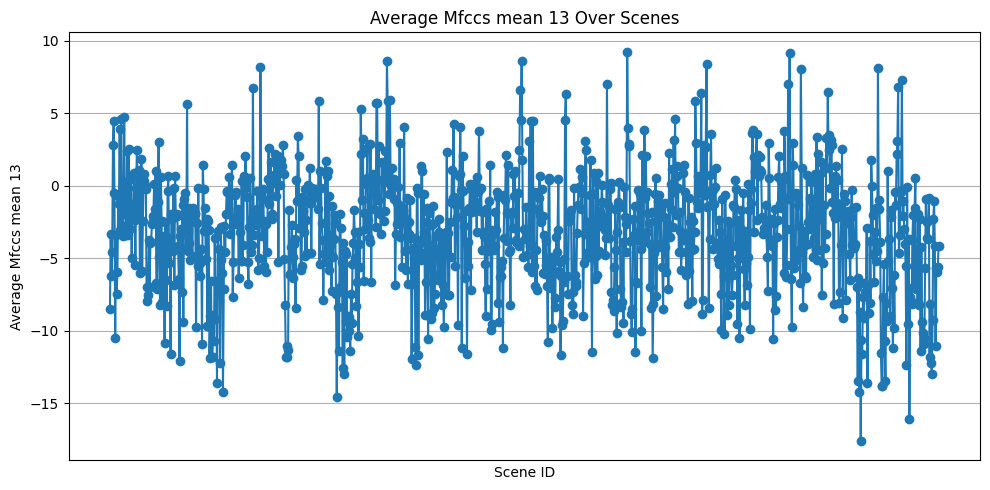

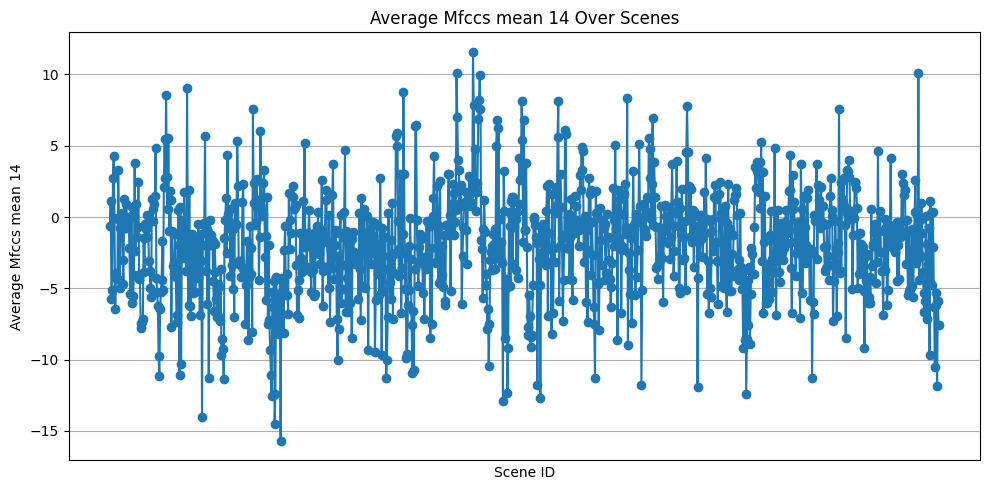

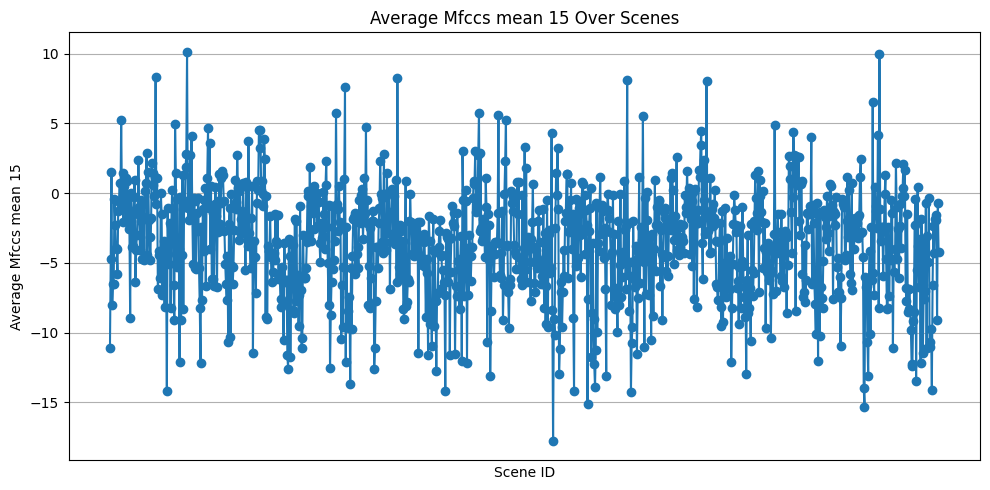

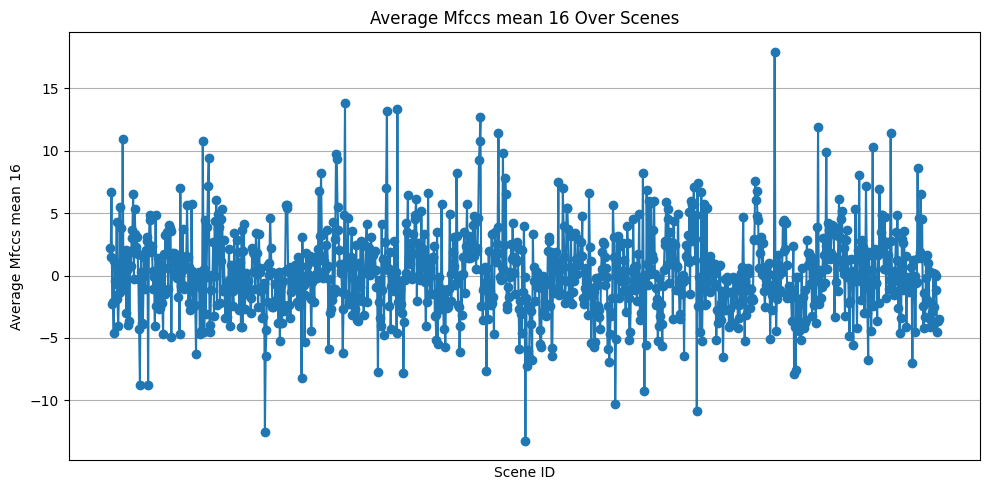

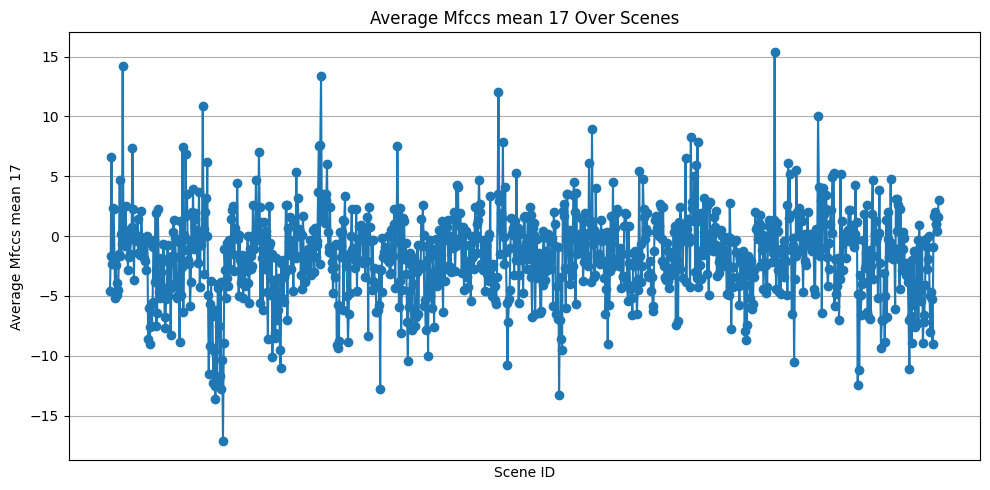

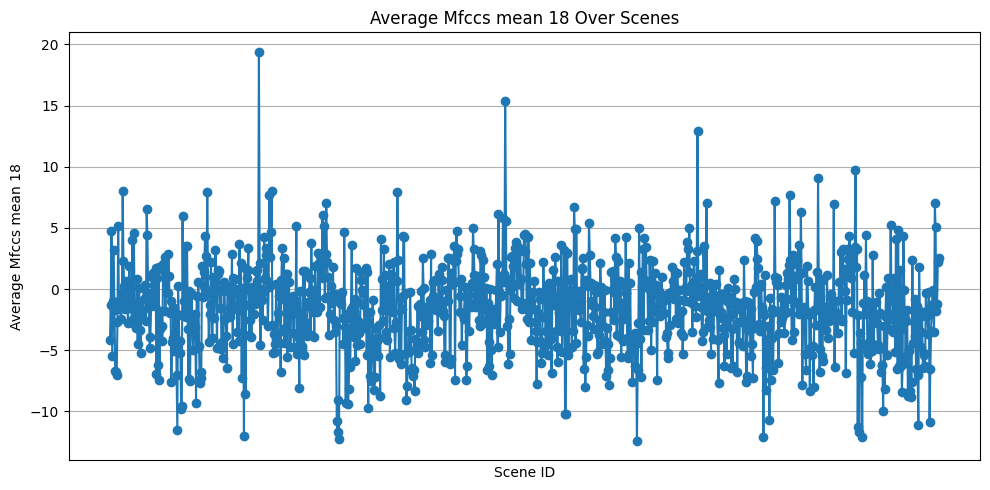

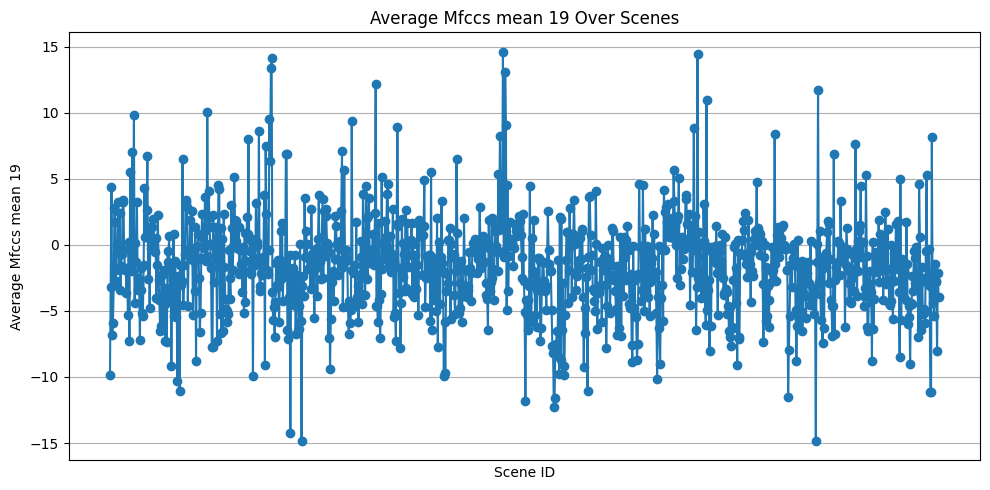

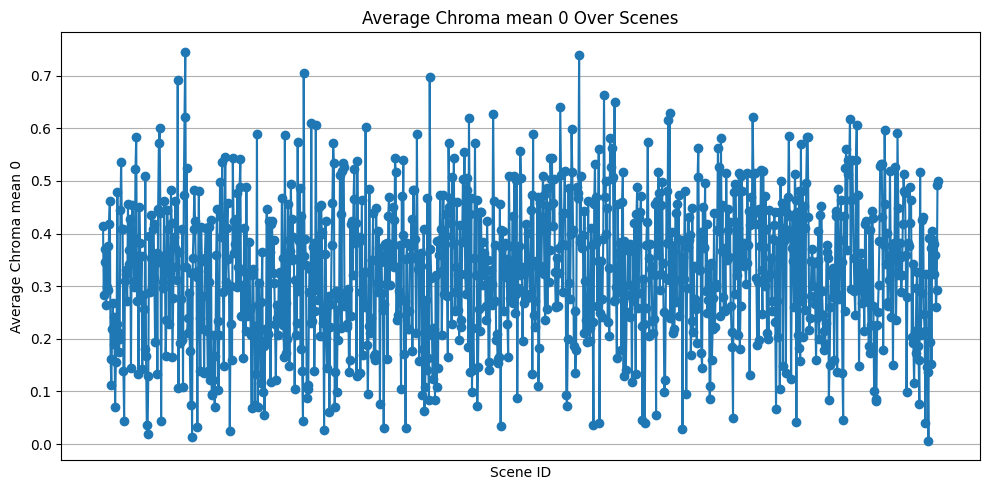

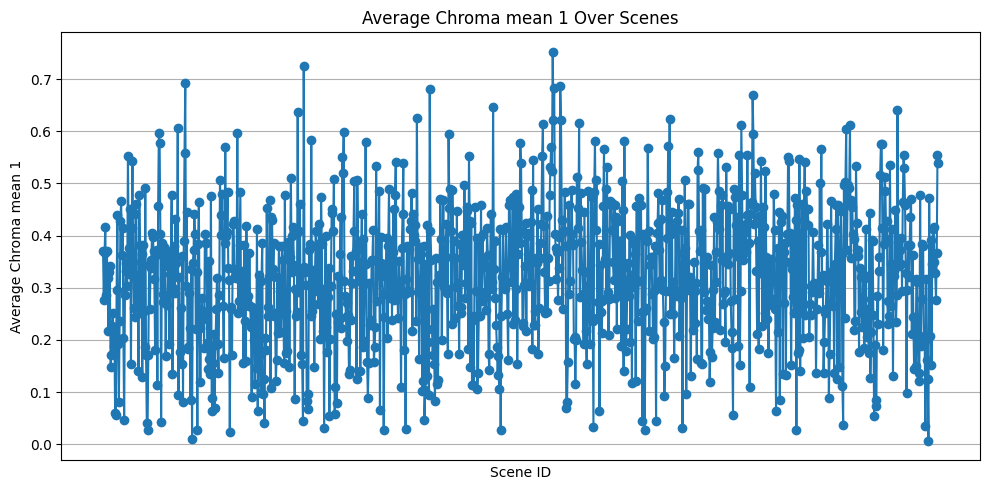

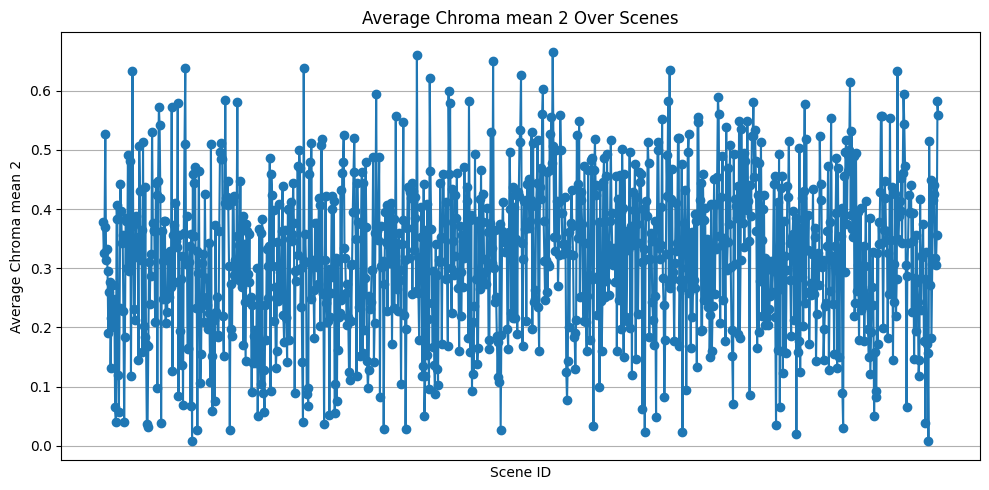

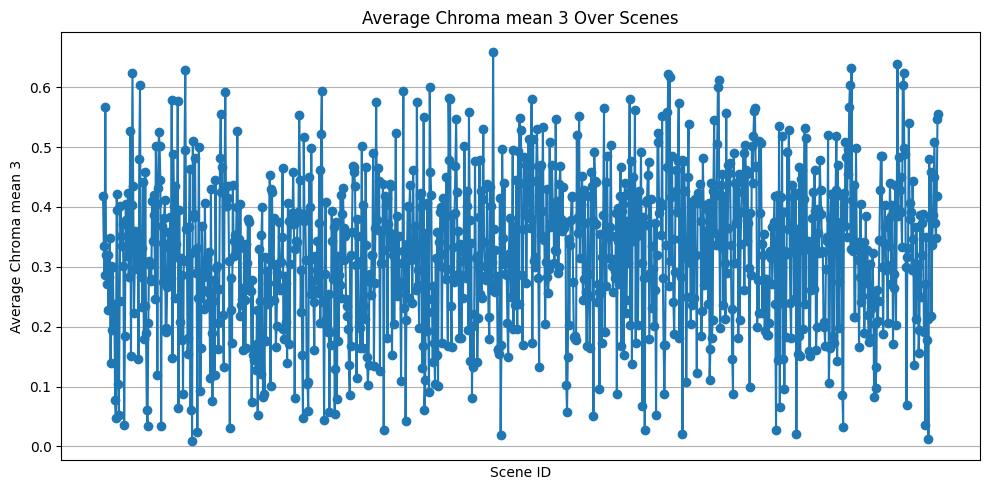

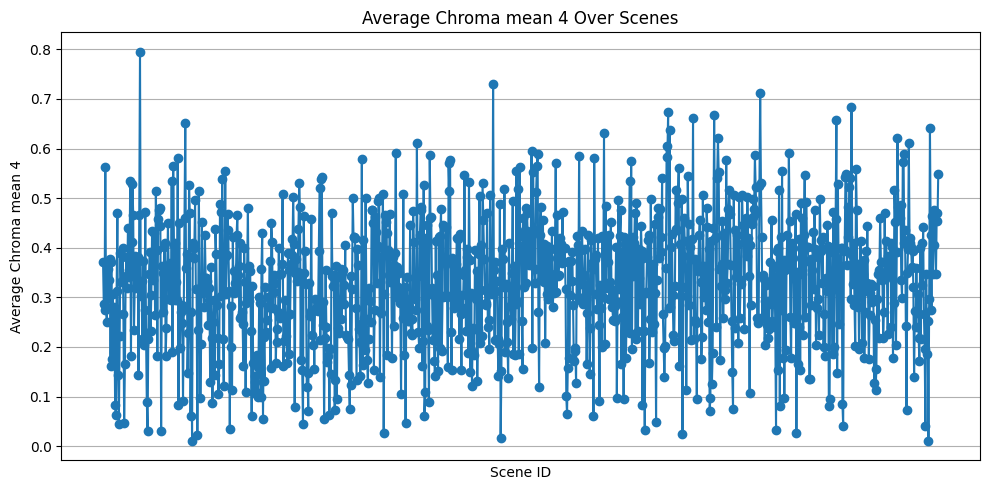

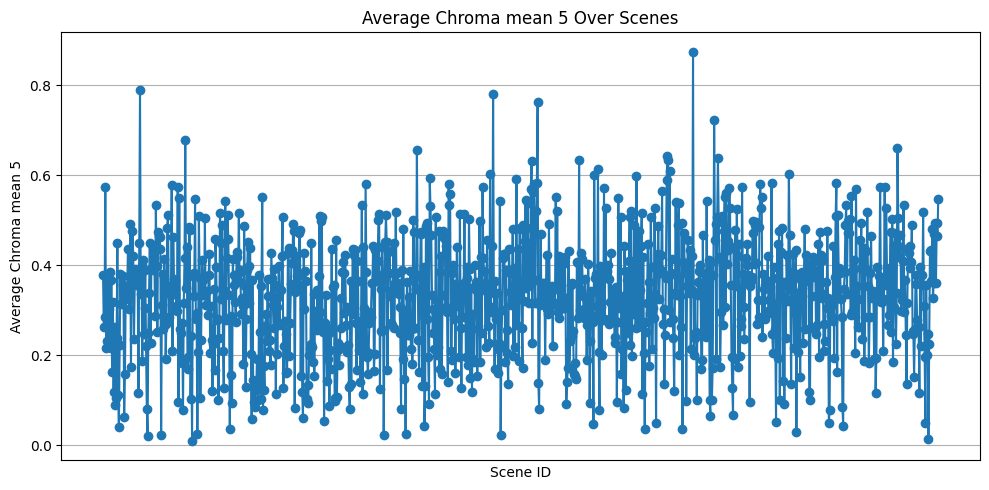

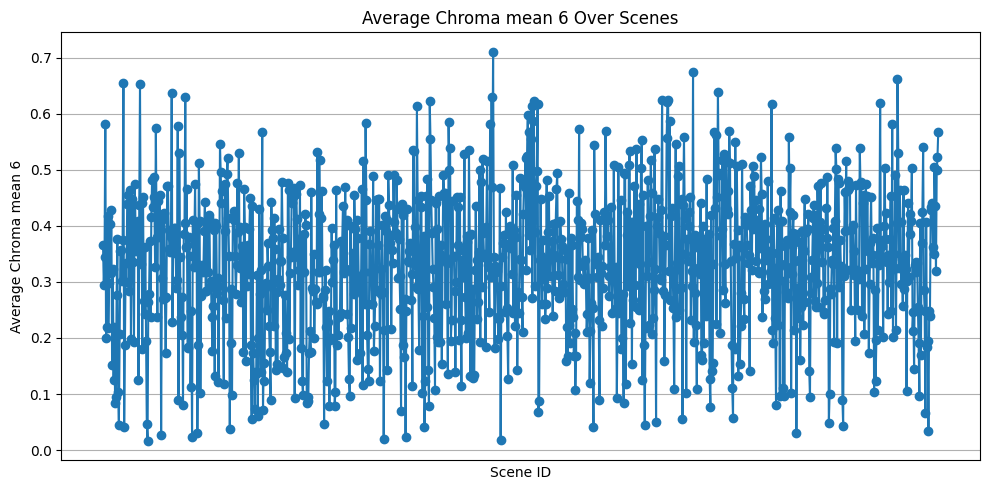

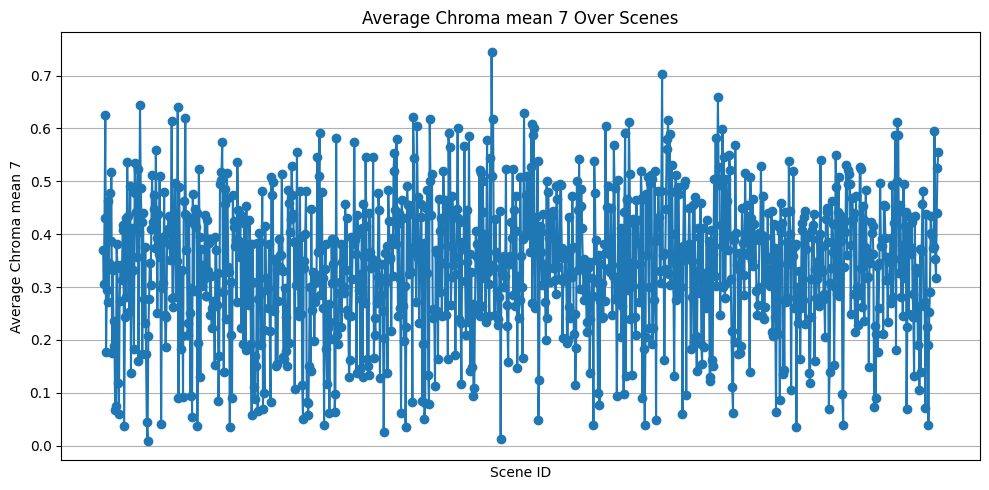

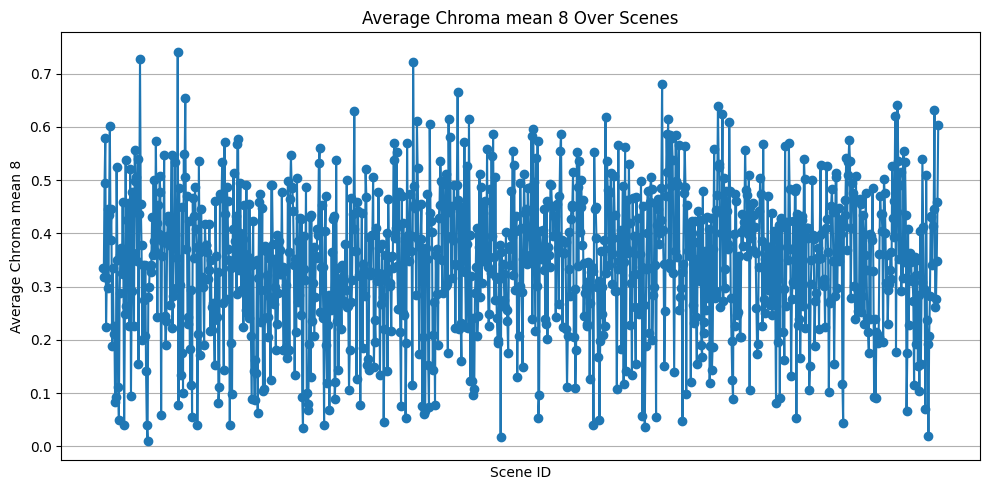

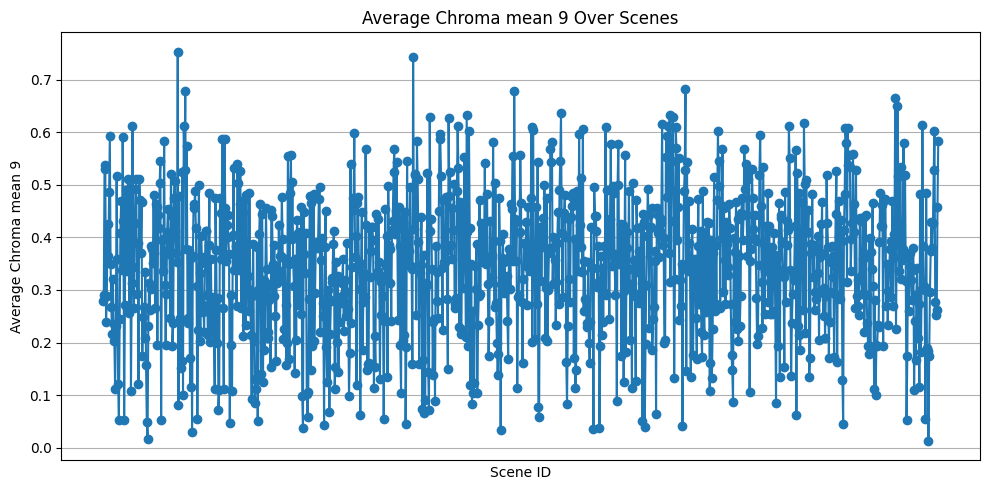

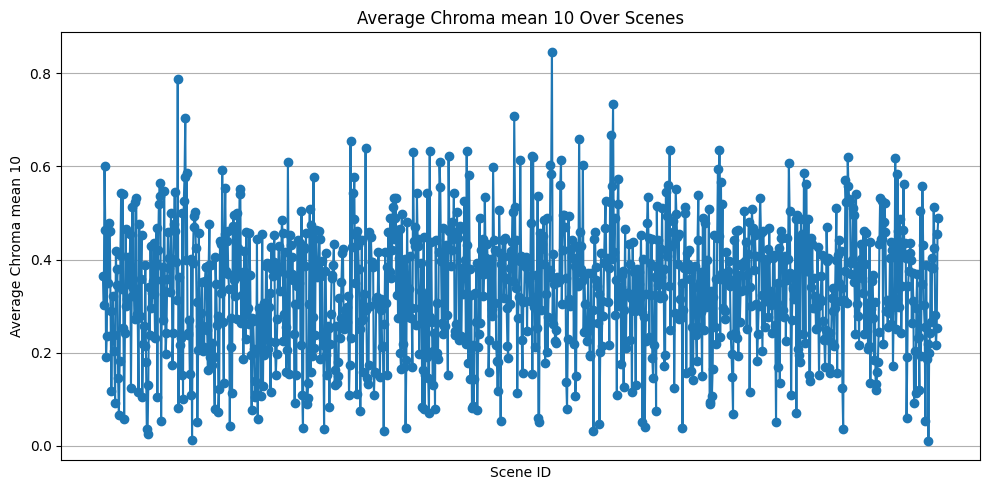

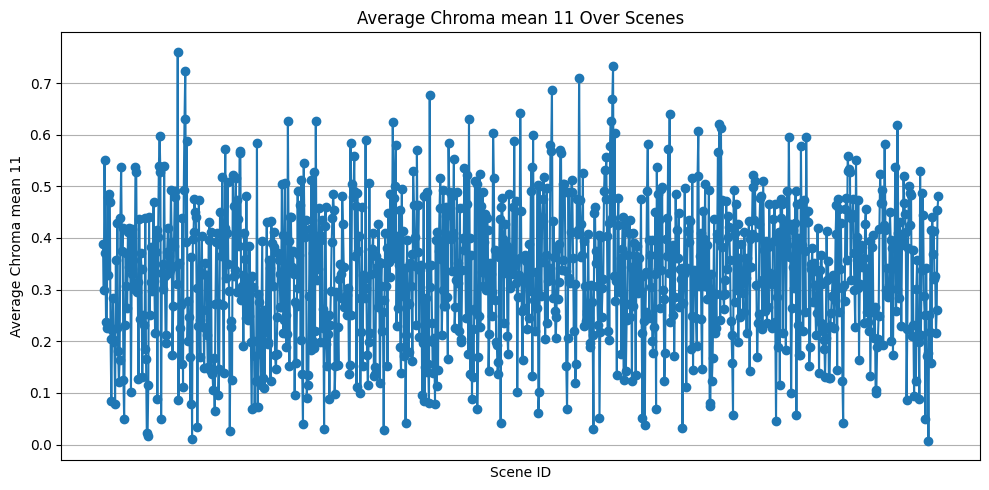

In [33]:
def plot_feature_over_scenes(feature_data, feature_name):
    """
    Plot a specified feature for each scene over time or sequence.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(feature_data['scene_id'], feature_data[feature_name], marker='o', linestyle='-')
    plt.title(f'Average {feature_name.replace("_", " ").capitalize()} Over Scenes')
    plt.xlabel('Scene ID')
    plt.ylabel(f'Average {feature_name.replace("_", " ").capitalize()}')
    plt.grid(True)
    plt.xticks([])  # Hides the x-axis labels
    plt.tight_layout()
    plt.show()

features_to_plot = [col for col in feature_data.columns if col != 'scene_id']

for feature in features_to_plot:
    plot_feature_over_scenes(feature_data, feature)
